In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import RENT

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.datasets import load_breast_cancer
wisconsin = load_breast_cancer()
data = pd.DataFrame(wisconsin.data)
data.columns = wisconsin.feature_names
target = wisconsin.target

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, target, random_state=0, shuffle=True)

In [4]:
train_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
293,11.85,17.46,75.54,432.7,0.08372,0.05642,0.026880,0.022800,0.1875,0.05715,0.2070,1.2380,1.234,13.88,0.007595,0.015000,0.014120,0.008578,0.01792,0.001784,13.06,25.75,84.35,517.8,0.1369,0.17580,0.13160,0.09140,0.3101,0.07007
332,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,0.2976,1.9660,1.959,19.62,0.012890,0.011040,0.003297,0.004967,0.04243,0.001963,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.097910,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.024230,0.039500,0.016780,0.01898,0.002498,23.69,38.25,155.00,1731.0,0.1166,0.19220,0.32150,0.16280,0.2572,0.06637
278,13.59,17.84,86.24,572.3,0.07948,0.04052,0.019970,0.012380,0.1573,0.05520,0.2580,1.1660,1.683,22.22,0.003741,0.005274,0.010650,0.005044,0.01344,0.001126,15.50,26.10,98.91,739.1,0.1050,0.07622,0.10600,0.05185,0.2335,0.06263
489,16.69,20.20,107.10,857.6,0.07497,0.07112,0.036490,0.023070,0.1846,0.05325,0.2473,0.5679,1.775,22.95,0.002667,0.014460,0.014230,0.005297,0.01961,0.001700,19.18,26.56,127.30,1084.0,0.1009,0.29200,0.24770,0.08737,0.4677,0.07623


In [5]:
# if paramter selection=True, it selects automatically C and l1 in a pre-training, otherwise tries all combinations.



# Define a range of regularisation parameters C for elastic net. A minimum of at least one value is required.
my_C_params = [0.1, 1, 10]

# Define a reange of l1-ratios for elastic net.  A minimum of at least one value is required.
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

analysis = RENT.RENT_Classification(data=train_data, 
                                    target=train_labels, 
                                    feat_names=train_data.columns, 
                                    C= my_C_params, 
                                    l1_ratios=my_l1_ratios,
                                    parameter_selection=False,
                                    poly='OFF',
                                    testsize_range=(0.25,0.25),
                                    scoring='mcc',
                                    method='logreg',
                                    K=100,
                                    verbose=0)

data dimension: (426, 30)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension (426,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
number of models in ensemble: 100
classification method: logreg
verbose: 0


In [6]:
analysis.train()

In [7]:
# can play around with enet parameter setting...
analysis.get_enet_params()

(1.0, 1.0)

In [8]:
# contain only one element as we did paramter selection beforehand...
scores, zeroes, harmonic_mean = analysis.get_enetParam_matrices()
scores

Scores,0.1,1.0,10.0
0.00,0.945064,0.954386,0.940014
0.10,0.943091,0.954420,0.939825
0.25,0.940361,0.955071,0.939237
0.50,0.932889,0.954062,0.938083
0.75,0.922392,0.950480,0.936551
0.90,0.919603,0.944903,0.933159
1.00,0.920026,0.943071,0.930981


In [9]:
zeroes

Zeroes,0.1,1.0,10.0
0.00,0,0,0
0.10,0.071,0.0316667,0.004
0.25,0.203,0.0956667,0.0273333
0.50,0.403667,0.215,0.062
0.75,0.561667,0.345333,0.106667
0.90,0.714667,0.442333,0.141667
1.00,0.788667,0.529667,0.164667


In [10]:
harmonic_mean

Harmonic Mean,0.1,1.0,10.0
0.00,0.000000,0.000000,0.000000
0.10,0.079252,0.038574,0.005027
0.25,0.178773,0.108179,0.032616
0.50,0.216294,0.212880,0.068307
0.75,0.070817,0.291338,0.105413
0.90,0.000000,0.313986,0.122197
1.00,0.011789,0.333296,0.126476


In [11]:
analysis.get_object_probabilities()

,K(1),K(2),K(3),K(4),K(5),K(6),K(7),K(8),K(9),K(10),K(11),K(12),K(13),K(14),K(15),K(16),K(17),K(18),K(19),K(20),K(21),K(22),K(23),K(24),K(25),K(26),K(27),K(28),K(29),K(30),K(31),K(32),K(33),K(34),K(35),K(36),K(37),K(38),K(39),K(40),K(41),K(42),K(43),K(44),K(45),K(46),K(47),K(48),K(49),K(50),K(51),K(52),K(53),K(54),K(55),K(56),K(57),K(58),K(59),K(60),K(61),K(62),K(63),K(64),K(65),K(66),K(67),K(68),K(69),K(70),K(71),K(72),K(73),K(74),K(75),K(76),K(77),K(78),K(79),K(80),K(81),K(82),K(83),K(84),K(85),K(86),K(87),K(88),K(89),K(90),K(91),K(92),K(93),K(94),K(95),K(96),K(97),K(98),K(99),K(100)
293,NaN,NaN,9.904896e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.939854e-01,9.944382e-01,NaN,NaN,9.960704e-01,NaN,NaN,NaN,9.937263e-01,NaN,NaN,NaN,9.922473e-01,NaN,NaN,9.906086e-01,9.940649e-01,9.946012e-01,NaN,NaN,NaN,9.963873e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.916154e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.928916e-01,NaN,NaN,9.917027e-01,NaN,NaN,NaN,NaN,NaN,9.931229e-01,NaN,9.945827e-01,NaN,NaN,NaN,9.940945e-01,9.928989e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.921140e-01,NaN,NaN,NaN,9.954555e-01,9.977818e-01,NaN,NaN,9.911781e-01,NaN,NaN,9.948750e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.923352e-01,NaN,9.982000e-01,9.942030e-01,NaN,NaN,NaN,NaN,9.958518e-01,NaN,9.938736e-01
332,NaN,9.990910e-01,NaN,NaN,NaN,NaN,NaN,9.992680e-01,9.990359e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.986761e-01,9.986813e-01,NaN,NaN,NaN,9.992878e-01,9.995390e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.988214e-01,NaN,NaN,9.995329e-01,NaN,9.989461e-01,9.989708e-01,NaN,NaN,NaN,NaN,NaN,9.989789e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.992920e-01,NaN,9.983177e-01,NaN,NaN,9.991112e-01,NaN,9.987533e-01,9.992093e-01,NaN,NaN,NaN,NaN,NaN,9.994019e-01,9.992495e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.982862e-01,9.995927e-01,9.993225e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.994254e-01
565,NaN,1.497645e-06,6.421978e-06,NaN,NaN,1.050972e-06,2.332093e-06,3.852756e-06,NaN,2.411954e-06,1.976325e-06,NaN,NaN,NaN,NaN,1.648916e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.048696e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.389947e-07,NaN,NaN,1.304963e-06,NaN,NaN,NaN,NaN,NaN,NaN,3.876236e-06,NaN,NaN,NaN,1.885239e-06,1.923457e-06,1.145839e-06,NaN,NaN,NaN,NaN,NaN,3.685845e-06,NaN,NaN,NaN,NaN,4.447484e-06,NaN,NaN,NaN,NaN,NaN,2.352360e-06,NaN,NaN,2.221168e-06,NaN,NaN,NaN,NaN,NaN,6.757924e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278,NaN,NaN,NaN,9.940158e-01,NaN,9.894689e-01,9.896302e-01,NaN,NaN,NaN,9.914271e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.892122e-01,9.870869e-01,NaN,NaN,NaN,NaN,NaN,9.855071e-01,NaN,9.844073e-01,NaN,NaN,NaN,NaN,9.929197e-01,NaN,9.916921e-01,NaN,NaN,NaN,NaN,9.884872e-01,NaN,NaN,9.877615e-01,9.925112e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.910918e-01,9.806576e-01,NaN,NaN,9.917626e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.924250e-01,NaN,9.936498e-01,9.937996e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.926103e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.908798e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.907783e-01,NaN,NaN,NaN,NaN
489,3.539825e-01,NaN,NaN,7.572532e-01,NaN,NaN,NaN,1.635112e-01,NaN,NaN,NaN,NaN,NaN,4.596874e-01,6.280383e-01,2.422430e-01,NaN,NaN,NaN,NaN,NaN,NaN,4.995157e-01,NaN,NaN,5.614830e-01,NaN,NaN,4.403722e-01,5.500224e-01,NaN,6.643173e-01,NaN,NaN,NaN,1.602354e-01,1.635696e-01,NaN,NaN,NaN,NaN,NaN,8.703905e-01,NaN,NaN,3.110799e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.111293e-01,NaN,NaN,1.220836e-01,NaN,NaN,NaN,NaN,NaN,NaN,5.528547e-01,NaN,NaN,5.068204e-01,NaN,5.998627e-01,NaN,NaN,NaN,NaN,NaN,NaN,6.146509e-01,NaN,4.013063e-01,6.555563e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.914268e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.010049e-01
346,NaN,9.983723e-01,NaN,NaN,NaN,9.973830e-01,NaN,NaN,NaN,9.972414e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.978533e-01,NaN,9.974949e-01,9.984644e-01,NaN,NaN,NaN,NaN,9.981356e-01,9.985415e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.983127e-01,NaN,NaN,9.965614e-01,NaN,NaN,NaN,NaN,9.978067e-01,9.959700e-01,Na

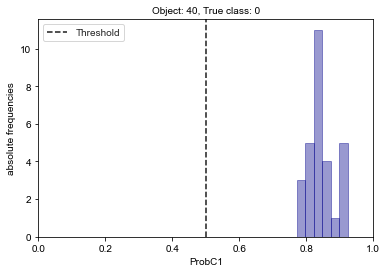

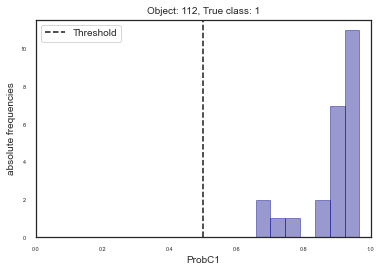

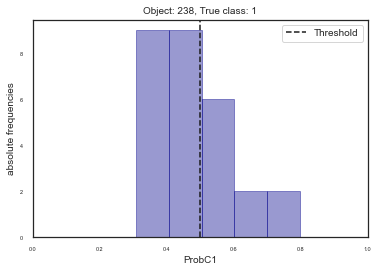

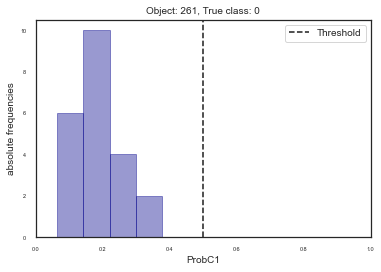

In [12]:
analysis.plot_object_probabilities(object_id=[40,112,238,261])

In [13]:
analysis.get_weight_distributions()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.000000,-0.180906,0.000000,0.000000,0.000000,0.0,0.000000,-0.883606,-0.341210,0.000000,-2.757998,0.000000,0.000000,0.000000,0.000000,0.970869,0.000000,0.000000,0.000000,0.401802,-1.544815,-1.139333,-0.191462,-1.426375,0.000000,0.000000,-0.907366,-1.649573,-0.351823,0.000000
1,0.000000,-0.140316,0.000000,0.000000,0.000000,0.0,0.000000,-0.810477,-0.300844,0.000000,-3.053780,0.000000,0.000000,0.000000,0.000000,0.323848,0.000000,0.000000,0.000000,0.785021,-1.360349,-1.148741,-0.978110,-1.017752,-0.101136,0.000000,-0.236852,-2.202400,-0.628460,0.000000
2,0.000000,-0.035142,0.000000,0.000000,0.000000,0.0,0.000000,-0.518945,-0.054613,0.000000,-3.236148,0.000000,0.000000,0.000000,0.000000,0.394078,0.000000,0.000000,0.000000,0.649877,-1.842251,-1.008839,-0.758810,0.000000,-0.224232,0.000000,-0.987837,-1.812394,-0.752890,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.900720,-0.121461,-0.218951,0.064320,-2.490583,0.000000,-0.599865,0.000000,0.000000,0.805773,0.000000,0.000000,0.000000,0.486582,-0.797444,-1.265634,-1.259663,-0.474317,-0.609201,0.000000,-0.310286,-1.908156,-0.290731,0.000000
4,0.000000,-0.425537,0.000000,0.000000,0.000000,0.0,0.000000,-0.554596,-0.331965,0.000000,-2.277119,0.205607,0.000000,0.000000,0.000000,0.611755,0.000000,0.000000,0.000000,0.355751,-2.019687,-1.287755,-0.823300,-1.018212,-0.304069,0.000000,-0.678409,-1.482806,-0.517475,0.000000
5,0.000000,-0.461786,0.000000,0.000000,0.000000,0.0,-0.331684,-0.114580,-0.083983,0.000000,-2.239332,0.000000,0.000000,0.000000,0.000000,0.785094,0.000000,0.000000,0.000000,0.183510,-2.551994,-0.847061,-1.492273,-0.738307,-0.413277,0.000000,-0.404757,-1.761026,-0.409352,0.000000
6,0.000000,-0.353075,0.000000,0.000000,-0.100960,0.0,0.000000,0.000000,-0.058121,0.000000,-2.566050,0.000000,0.000000,0.000000,0.000000,0.667817,0.000000,0.000000,0.000000,0.295916,-1.588574,-1.011287,-1.881435,0.000000,-0.065233,0.000000,-0.744542,-2.172367,-0.441437,-0.018125
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.435962,0.039058,-0.353422,0.000000,0.000000,-0.556497,0.000000,0.103275,0.000000,0.000000,0.000000,0.085531,-2.730135,-1.588115,0.000000,-2.816349,-0.861442,0.000000,-0.489559,-1.521093,-0.521476,0.000000
8,0.000000,-0.462966,0.000000,0.000000,0.000000,0.0,0.000000,-1.281557,-0.185346,0.000000,-2.461366,0.000000,-0.202839,0.000000,0.000000,1.094131,0.000000,0.000000,0.000000,0.226214,-1.514544,-0.807842,-1.438883,-0.176758,-0.064953,0.000000,-0.972477,-1.193923,-0.486892,-0.207613
9,0.000000,-0.006528,0.000000,0.000000,0.000000,0.0,0.000000,-0.367208,-0.408313,0.000000,-2.643861,0.000000,0.000000,0.000000,0.000000,0.850659,0.000000,0.000000,0.000000,0.436978,-0.958477,-1.317072,-0.601001,-1.441171,-0.081440,0.000000,-0.856769,-2.081255,-0.466760,0.000000


In [14]:
analysis.summary_objects()

,# test,class,# incorrect,% incorrect
293,27,1,0,0.000000
332,23,1,0,0.000000
565,20,0,0,0.000000
278,22,1,0,0.000000
489,25,0,12,48.000000
346,25,1,0,0.000000
357,30,1,0,0.000000
355,28,1,0,0.000000
112,24,1,0,0.000000
68,26,1,4,15.384615


In [15]:
fs_vars = analysis.selectFeatures(tau_1=0.9, tau_2=0.9, tau_3=0.975)

In [16]:
analysis.summary_criteria()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
tau_1,0.050000,0.71,0.020000,0.010000,0.130000,0.0,0.160000,0.88,0.87,0.060000,0.99,0.14000,0.210000,0.090000,0.090000,0.93,0.020000,0.010000,0.090000,0.91,0.99,1.0,0.95,0.68,0.81,0.010000,1.0,0.99,0.94,0.37
tau_2,0.050000,0.71,0.020000,0.010000,0.130000,0.0,0.160000,0.88,0.87,0.060000,0.99,0.10000,0.210000,0.090000,0.030000,0.93,0.020000,0.010000,0.090000,0.91,0.99,1.0,0.95,0.68,0.81,0.010000,1.0,0.99,0.94,0.37
tau_3,0.987411,1.00,0.919081,0.841336,0.997907,NaN,0.999692,1.00,1.00,0.974571,1.00,0.99758,0.999867,0.992514,0.549326,1.00,0.855056,0.841336,0.994162,1.00,1.00,1.0,1.00,1.00,1.00,0.841336,1.0,1.00,1.00,1.00


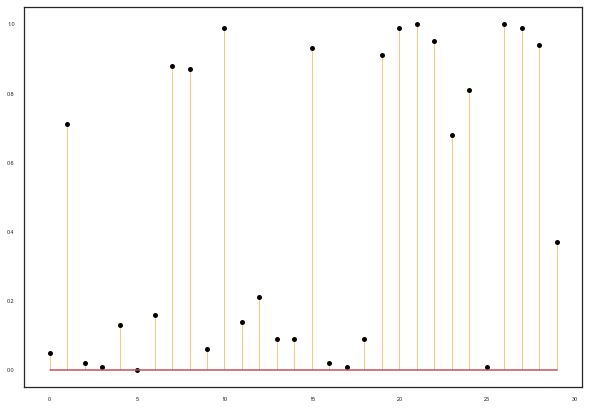

In [17]:
analysis.plot_selection_frequency()

In [18]:
analysis.get_runtime()

'204.969s'

loo


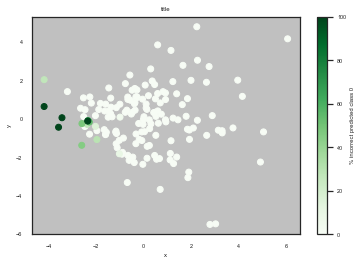

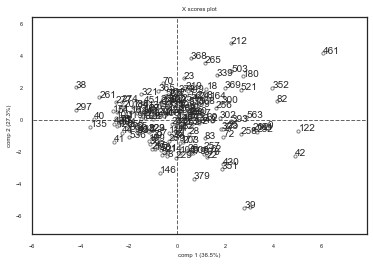

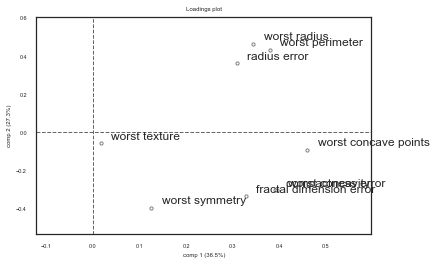

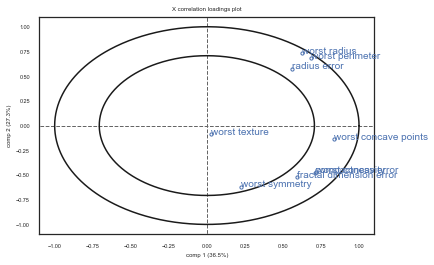

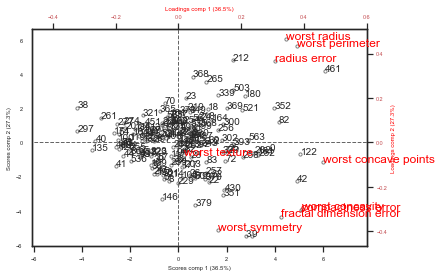

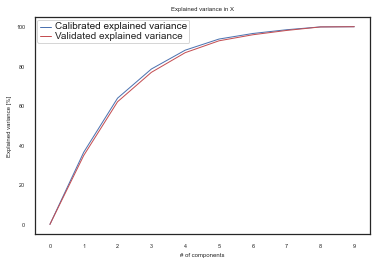

In [19]:
analysis.plot_object_PCA(group=0)

loo


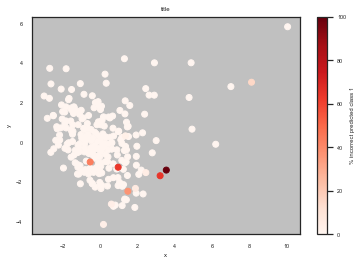

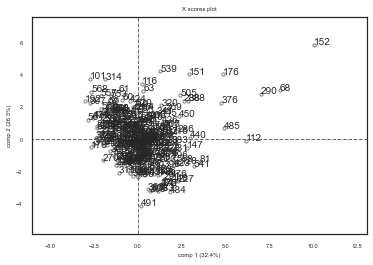

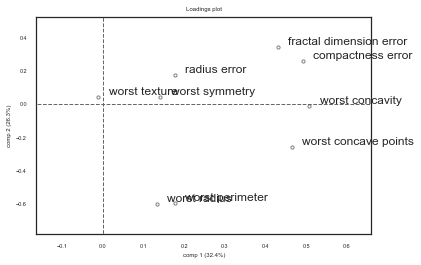

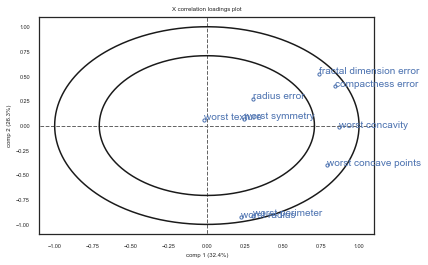

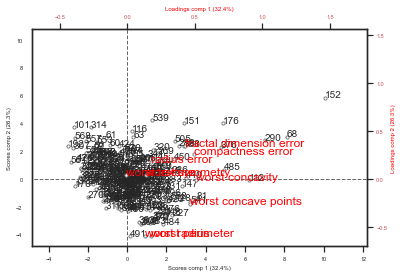

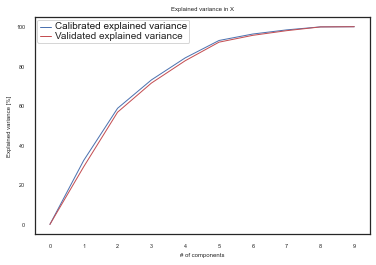

In [20]:
analysis.plot_object_PCA(group=1)

loo


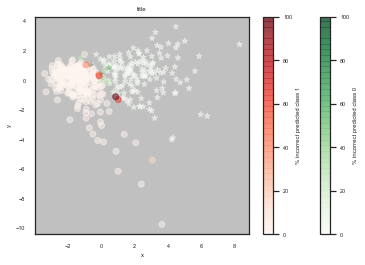

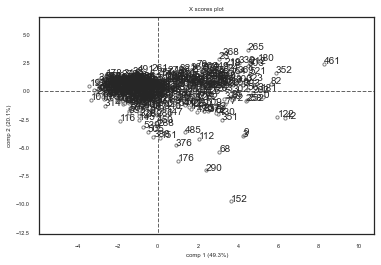

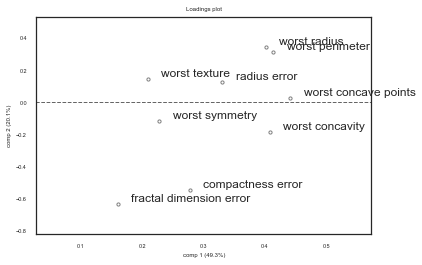

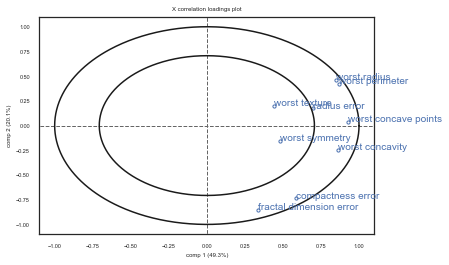

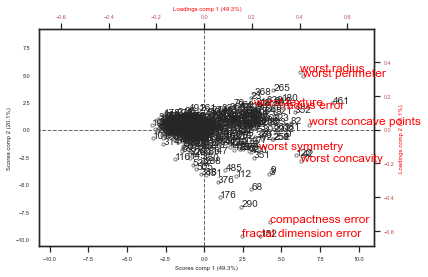

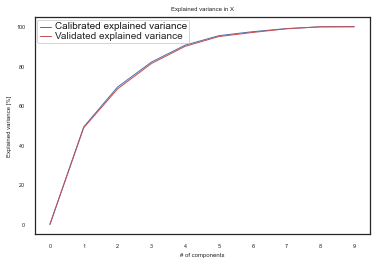

In [21]:
analysis.plot_object_PCA(group='both')

In [22]:
#predit test data

# Import what is needed for prediction and evaluation of predictions from test set
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

# Scale the data accordingly
sc = StandardScaler()
train_data_1 = sc.fit_transform(train_data.iloc[:, fs_vars])
test_data_1 = sc.transform(test_data.iloc[:, fs_vars])

# Train model with 
model = LR(penalty='none', max_iter=8000, solver="saga", random_state=0).\
        fit(train_data_1, train_labels)

# Print results
print("f1 1: ", f1_score(test_labels, model.predict(test_data_1)))
print("f1 0: ", f1_score(1 - test_labels, 1 - model.predict(test_data_1)))
print("Accuracy: ", accuracy_score(test_labels, model.predict(test_data_1)))
print("Matthews correlation coefficient: ", matthews_corrcoef(test_labels, model.predict(test_data_1)))


f1 1:  0.9491525423728815
f1 0:  0.9174311926605505
Accuracy:  0.9370629370629371
Matthews correlation coefficient:  0.8675034270773535
